In [ ]:
# Load Libraries
import pandas as pd
import numpy as np
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt

In [ ]:
# Seed
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change the current working directory
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load Features
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763/Data')
Data1 = loadmat('p5763_Set1_Inputs.mat')
Data2 = loadmat('p5763_Set1_Outputs.mat')
Features = pd.DataFrame({'Time':Data1['Time'].ravel().round(2),'K':Data1['K'].ravel().round(2),'V':Data1['V'].ravel().round(2),'AE':Data1['AE'].ravel().round(2),
                         'ln_V0_Theta':Data1['ln_V0_Theta'].ravel().round(2),'Amp':Data1['Amp'].ravel().round(2)})
Output = pd.DataFrame({'Time':Data2['Time'].ravel().round(2),'SS':Data2['SS'].ravel().round(2),'ln_V_V0':Data2['ln_V_V0'].ravel().round(2),'TTF':Data2['TTF'].ravel().round(2),
                       'physics_out':Data2['physics_out'].ravel().round(2)})
df = Features.merge(Output, on = 'Time')
df = df[['K','V','AE','Amp','ln_V0_Theta','SS','TTF','ln_V_V0','physics_out','Time']]
df_AE = df[['AE','AE']]
df_SS = df[['K','V','AE','Amp','SS']]
df_TTF = df[['K','V','AE','Amp','TTF']]
df_SR = df[['K','V','AE','Amp','ln_V_V0']]
df_A = df[['K','V','AE','Amp','ln_V0_Theta']]
df_PhyOut = df[['K','V','AE','Amp','physics_out']]
xdf = df[['K','V','AE','Amp']]
ydf = df[['SS','TTF','ln_V_V0']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
             K      V    AE      Amp
0     5957.24  17.78  2.00  2090.29
1     5960.89  17.79  2.00  2072.79
2     6214.84  17.81  2.00  2078.77
3     4543.97  17.74  2.00  2085.99
4     4554.15  17.76  1.67  2066.37
...       ...    ...   ...      ...
9495  1033.99  16.82  2.00  1720.64
9496  1032.72  16.81  2.00  1742.58
9497  1032.13  16.81  1.67  1732.37
9498  1032.36  16.81  1.67  1693.09
9499  1114.37  16.83  1.50  1704.66

[9500 rows x 4 columns]
Target Data:
         SS   TTF  ln_V_V0
0     6.05  0.00   -11.51
1     6.06  0.00   -11.51
2     6.06  0.00   -11.51
3     6.07  0.00   -11.51
4     6.07  0.00   -11.51
...    ...   ...      ...
9495  5.92  6.55   -11.51
9496  5.92  6.45   -11.51
9497  5.93  6.34   -11.51
9498  5.93  6.23   -11.51
9499  5.94  6.12   -11.51

[9500 rows x 3 columns]


In [ ]:
# Preprocessing (AE)
arr = df_AE.to_numpy()
n_steps = 100
xdf_AE, ydf_AE = create_timesteps(arr, n_steps)

# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 100
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (TTF)
arr = df_TTF.to_numpy()
n_steps = 100
xdf, ydf_TTF = create_timesteps(arr, n_steps)

# Preprocessing (SR)
arr = df_SR.to_numpy()
n_steps = 100
xdf, ydf_SR = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 100
xdf, Adf = create_timesteps(arr, n_steps)

# Preprocessing (Physics_Out)
arr = df_PhyOut.to_numpy()
n_steps = 100
xdf, phy_outdf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (TTF), Y = ', np.shape(ydf_TTF))
print('Target shape (SR), Y = ', np.shape(ydf_SR))
print('Target shape (AE), Y = ', np.shape(ydf_AE))
print('Target shape (A), Y = ', np.shape(Adf))
print('Target shape (Physics_Out), Y = ', np.shape(phy_outdf))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

# Reshape AE
in_dim = xdf_AE.shape[1]*xdf_AE.shape[2]
xdf_AE = xdf_AE.reshape((xdf_AE.shape[0], in_dim))
print('After reshaping, xdf_AE = ', np.shape(xdf_AE))

Features shape, X =  (9400, 100, 4)
Target shape (SS), Y =  (9400,)
Target shape (TTF), Y =  (9400,)
Target shape (SR), Y =  (9400,)
Target shape (AE), Y =  (9400,)
Target shape (A), Y =  (9400,)
Target shape (Physics_Out), Y =  (9400,)
After reshaping, X =  (9400, 400)
After reshaping, xdf_AE =  (9400, 100)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.111, shuffle=False)

# Split into train-val-test (TTF)
x_train, x_test, y_train_TTF, y_test_TTF = train_test_split(xdf, ydf_TTF, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_TTF, Y_val_TTF = train_test_split(x_train, y_train_TTF, test_size=0.111, shuffle=False)

# Split into train-val-test (SR)
x_train, x_test, y_train_SR, y_test_SR = train_test_split(xdf, ydf_SR, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_SR, Y_val_SR = train_test_split(x_train, y_train_SR, test_size=0.111, shuffle=False)

# Split into train-val-test (AE)
x_train, x_test, y_train_AE, y_test_AE = train_test_split(xdf, xdf_AE, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_AE, Y_val_AE = train_test_split(x_train, y_train_AE, test_size=0.111, shuffle=False)

# Split into train-val-test (A)
x_train, x_test, y_train_A, y_test_A = train_test_split(xdf, Adf, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_A, Y_val_A = train_test_split(x_train, y_train_A, test_size=0.111, shuffle=False)

# Split into train-val-test (Physics Out)
x_train, x_test, y_train_Phy, y_test_Phy = train_test_split(xdf, phy_outdf, test_size=0.1, shuffle=False)
X_train, X_val, Y_train_Phy, Y_val_Phy = train_test_split(x_train, y_train_Phy, test_size=0.111, shuffle=False)

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 7520
Validation samples: 940
Testing samples: 940


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler(feature_range=(0, 1))
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: TTF
scaler_ttf = MinMaxScaler(feature_range=(0, 1))
Y_train_TTF = pd.DataFrame(scaler_ttf.fit_transform(Y_train_TTF.reshape(-1, 1)))
Y_val_TTF = pd.DataFrame(scaler_ttf.transform(Y_val_TTF.reshape(-1, 1)))
y_test_TTF = pd.DataFrame(scaler_ttf.transform(y_test_TTF.reshape(-1, 1)))

In [ ]:
# # Normalize the output: SR
scaler_sr = MinMaxScaler(feature_range=(-1, 1))
Y_train_SR = pd.DataFrame(scaler_sr.fit_transform(Y_train_SR.reshape(-1, 1)))
Y_val_SR = pd.DataFrame(scaler_sr.transform(Y_val_SR.reshape(-1, 1)))
y_test_SR = pd.DataFrame(scaler_sr.transform(y_test_SR.reshape(-1, 1)))

In [ ]:
# Normalize the input: AE
scaler_ae = MinMaxScaler(feature_range=(0, 1))
Y_train_AE = pd.DataFrame(scaler_ae.fit_transform(Y_train_AE))
Y_val_AE = pd.DataFrame(scaler_ae.transform(Y_val_AE))
y_test_AE = pd.DataFrame(scaler_ae.transform(y_test_AE))

In [ ]:
# Normalize Amp
scaler_A = MinMaxScaler(feature_range=(0, 1))
Y_train_A = pd.DataFrame(scaler_A.fit_transform(Y_train_A.reshape(-1, 1)))
Y_val_A = pd.DataFrame(scaler_A.transform(Y_val_A.reshape(-1, 1)))
y_test_A = pd.DataFrame(scaler_A.transform(y_test_A.reshape(-1, 1)))

In [ ]:
# Define Physics
# Rate and State Friction
# mu  = mu0 + a*ln(V/V0)+ b*ln(V0*Theta/Dc)
# SS = C1 + C2ln(V/V0) + C3ln(V0*Theta/Dc)

class gradient_1(tf.keras.layers.Layer):
  def __init__(self):
    super(gradient_1,self).__init__()
    self.SS = tf.keras.layers.Dense(1)
    self.SR = tf.keras.layers.Dense(1)
    self.A = tf.keras.layers.Dense(1)
    self.all_scale = tf.keras.layers.Dense(1)
    self.c1 = self.add_weight("c1",trainable=True)
    self.c2 = self.add_weight("c2",trainable=True)
    self.c3 = self.add_weight("c3",trainable=True)
    self.c4 = self.add_weight("c4",trainable=True)
  def call(self, params):
    ss_pred, sr_pred, Amp = params
    ss_pred = self.SS(ss_pred)
    sr_pred = self.SR(sr_pred)
    Amp = self.A(Amp)

    term1 =  ss_pred
    term2 =  sr_pred
    term3 =  Amp - self.c4

    term4 = tf.multiply(self.c2,term2)
    term5 = tf.multiply(self.c3,term3)

    eqn = term1-self.c1-term4-term5
    eqn = self.all_scale(eqn)

    return eqn

In [ ]:
# Define PINN
def MLP_Physics():

  # Define inputs
  X_train = layers.Input(shape=(400),name='X_train')
  AE =layers.Input(shape=(100),name='AE')
  Amp =layers.Input(shape=(1),name='Amp')

  # Prediction: Shear Stress + TTF
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)

  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  ttf_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  # Prediction: SR
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(AE)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  sr_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x) # softplus, linear

  grad_out = gradient_1()([ss_pred,sr_pred,Amp])
  model = keras.Model(inputs=[X_train,AE,Amp],outputs=[ss_pred,ttf_pred,sr_pred,grad_out])
  return model

In [ ]:
# Model Summary
model=MLP_Physics()
model.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 X_train (InputLayer)        [(None, 400)]                0         []                            
                                                                                                  
 AE (InputLayer)             [(None, 100)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  51328     ['X_train[0][0]']             
                                                                                                  
 dense_7 (Dense)             (None, 128)                  12928     ['AE[0][0]']                  
                                                                                              

Train on 7520 samples, validate on 940 samples
Epoch 1/100
7520/7520 [==============================] - 2s 229us/sample - loss: 0.4537 - dense_5_loss: 0.0865 - dense_6_loss: 0.0987 - dense_12_loss: 0.2596 - gradient_1_loss: 0.0090 - dense_5_mse: 0.0865 - dense_6_mse: 0.0987 - dense_12_mse: 0.2596 - gradient_1_mse: 0.0090 - val_loss: 0.2270 - val_dense_5_loss: 0.0438 - val_dense_6_loss: 0.1320 - val_dense_12_loss: 0.0420 - val_gradient_1_loss: 0.0082 - val_dense_5_mse: 0.0441 - val_dense_6_mse: 0.1319 - val_dense_12_mse: 0.0427 - val_gradient_1_mse: 0.0083
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7520/7520 [==============================] - 1s 131us/sample - loss: 0.1574 - dense_5_loss: 0.0280 - dense_6_loss: 0.0894 - dense_12_loss: 0.0388 - gradient_1_loss: 0.0012 - dense_5_mse: 0.0280 - dense_6_mse: 0.0894 - dense_12_mse: 0.0388 - gradient_1_mse: 0.0012 - val_loss: 0.1607 - val_dense_5_loss: 0.0258 - val_dense_6_loss: 0.0916 - val_dense_12_loss: 0.0353 - val_gradient_1_loss: 0.0073 - val_dense_5_mse: 0.0257 - val_dense_6_mse: 0.0917 - val_dense_12_mse: 0.0360 - val_gradient_1_mse: 0.0073
Epoch 3/100
7520/7520 [==============================] - 1s 130us/sample - loss: 0.0546 - dense_5_loss: 0.0071 - dense_6_loss: 0.0129 - dense_12_loss: 0.0327 - gradient_1_loss: 0.0020 - dense_5_mse: 0.0071 - dense_6_mse: 0.0129 - dense_12_mse: 0.0327 - gradient_1_mse: 0.0020 - val_loss: 0.0613 - val_dense_5_loss: 0.0117 - val_dense_6_loss: 0.0117 - val_dense_12_loss: 0.0308 - val_gradient_1_loss: 0.0063 - val_dense_5_mse: 0.0117 - val_dense_6_mse: 0.0118 - val_dense_12_mse: 0.0314 - val_gradi

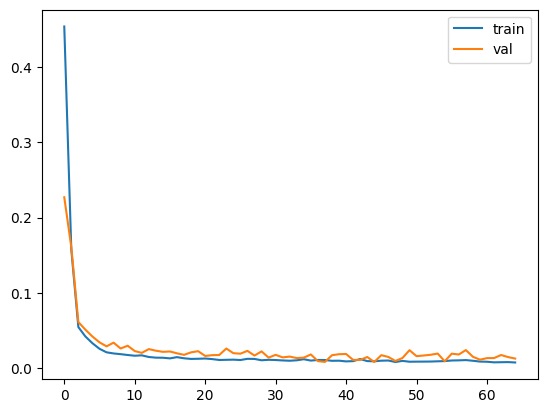

---Training time: 82.32760119 seconds ---


In [ ]:
# Train The Model
start_time = time.time()
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')
callbacks_list = [earlystop]
history = model.fit([X_train,Y_train_AE,Y_train_A],[Y_train_SS,Y_train_TTF,Y_train_SR,Y_train_Phy], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val,Y_val_AE,Y_val_A],[Y_val_SS,Y_val_TTF,Y_val_SR,Y_val_Phy]), verbose=1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
end_time = time.time()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # # Save the model
print(model.summary())
model.save('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5763/Standalone_Model/PINN_1/Include_Trend/80_10_10/PINN_1_Transfer_model_80_10_10.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 X_train (InputLayer)        [(None, 400)]                0         []                            
                                                                                                  
 AE (InputLayer)             [(None, 100)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  51328     ['X_train[0][0]']             
                                                                                                  
 dense_7 (Dense)             (None, 128)                  12928     ['AE[0][0]']                  
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Predictions: Training
y_predtrain = model.predict([X_train,Y_train_AE,Y_train_A])
y_predtrain_SS = np.array(y_predtrain)[0,]
y_predtrain_TTF =np.array(y_predtrain)[1,]
y_predtrain_SR =np.array(y_predtrain)[2,]

# Predictions: Validation
y_predval = model.predict([X_val,Y_val_AE,Y_val_A])
y_predval_SS = np.array(y_predval)[0,]
y_predval_TTF =np.array(y_predval)[1,]
y_predval_SR =np.array(y_predval)[2,]

# Predictions: Testing
y_predtest = model.predict([x_test,y_test_AE,y_test_A])
y_predtest_SS = np.array(y_predtest)[0,]
y_predtest_TTF =np.array(y_predtest)[1,]
y_predtest_SR =np.array(y_predtest)[2,]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# Inverse scaling: SS
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: TTF
Y_train_TTF = scaler_ttf.inverse_transform(Y_train_TTF)
Y_val_TTF = scaler_ttf.inverse_transform(Y_val_TTF)
y_test_TTF = scaler_ttf.inverse_transform(y_test_TTF)
y_predtrain_TTF = scaler_ttf.inverse_transform(y_predtrain_TTF)
y_predval_TTF = scaler_ttf.inverse_transform(y_predval_TTF)
y_predtest_TTF = scaler_ttf.inverse_transform(y_predtest_TTF)

In [ ]:
# Inverse scaling: SR
Y_train_SR = scaler_sr.inverse_transform(Y_train_SR)
Y_val_SR = scaler_sr.inverse_transform(Y_val_SR)
y_test_SR = scaler_sr.inverse_transform(y_test_SR)
y_predtrain_SR = scaler_sr.inverse_transform(y_predtrain_SR)
y_predval_SR = scaler_sr.inverse_transform(y_predval_SR)
y_predtest_SR = scaler_sr.inverse_transform(y_predtest_SR)

In [ ]:
# Model Performance: Training
train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS)
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS))

train_r2_TTF = r2_score(Y_train_TTF, y_predtrain_TTF)
train_rmse_TTF = np.sqrt(mean_squared_error(Y_train_TTF, y_predtrain_TTF))

train_r2_SR = r2_score(Y_train_SR, y_predtrain_SR)
train_rmse_SR = np.sqrt(mean_squared_error(Y_train_SR, y_predtrain_SR))

# Model Performance: Validation
val_r2_SS = r2_score(Y_val_SS, y_predval_SS)
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS))

val_r2_TTF = r2_score(Y_val_TTF, y_predval_TTF)
val_rmse_TTF = np.sqrt(mean_squared_error(Y_val_TTF, y_predval_TTF))

val_r2_SR = r2_score(Y_val_SR, y_predval_SR)
val_rmse_SR = np.sqrt(mean_squared_error(Y_val_SR, y_predval_SR))

# Model Performance: Testing
test_r2_SS = r2_score(y_test_SS, y_predtest_SS)
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS))

test_r2_TTF = r2_score(y_test_TTF, y_predtest_TTF)
test_rmse_TTF = np.sqrt(mean_squared_error(y_test_TTF, y_predtest_TTF))

test_r2_SR = r2_score(y_test_SR, y_predtest_SR)
test_rmse_SR = np.sqrt(mean_squared_error(y_test_SR, y_predtest_SR))

In [ ]:
# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (TTF) - %0.5f, Train (SR) - %0.5f" %(train_r2_SS, train_r2_TTF, train_r2_SR))
print("R2 scores: Val (SS) - %0.5f, Val (TTF) - %0.5f, Val (SR) - %0.5f" %(val_r2_SS,val_r2_TTF,val_r2_SR))
print("R2 scores: Test (SS) - %0.5f, Test (TTF) - %0.5f, Test (SR) - %0.5f" %(test_r2_SS,test_r2_TTF,test_r2_SR))

R2 scores: Train (SS) - 0.98023, Train (TTF) - 0.95830, Train (SR) - 0.93910
R2 scores: Val (SS) - 0.95099, Val (TTF) - 0.96039, Val (SR) - 0.87663
R2 scores: Test (SS) - 0.83060, Test (TTF) - 0.88813, Test (SR) - 0.97685


In [ ]:
# Print RMSE Results
print("RMSE: Train (SS) - %0.5f, Train (TTF) - %0.5f, Train (SR) - %0.5f" %(train_rmse_SS, train_rmse_TTF, train_rmse_SR))
print("RMSE: Val (SS) - %0.5f, Val (TTF) - %0.5f, Val (SR) - %0.5f" %(val_rmse_SS, val_rmse_TTF, val_rmse_SR))
print("RMSE: Test (SS) - %0.5f, Test (TTF) - %0.5f, Test (SR) - %0.5f" %(test_rmse_SS, test_rmse_TTF, test_rmse_SR))

RMSE: Train (SS) - 0.01902, Train (TTF) - 0.58490, Train (SR) - 0.36245
RMSE: Val (SS) - 0.03436, Val (TTF) - 0.63982, Val (SR) - 0.50582
RMSE: Test (SS) - 0.06233, Test (TTF) - 1.03935, Test (SR) - 0.20955


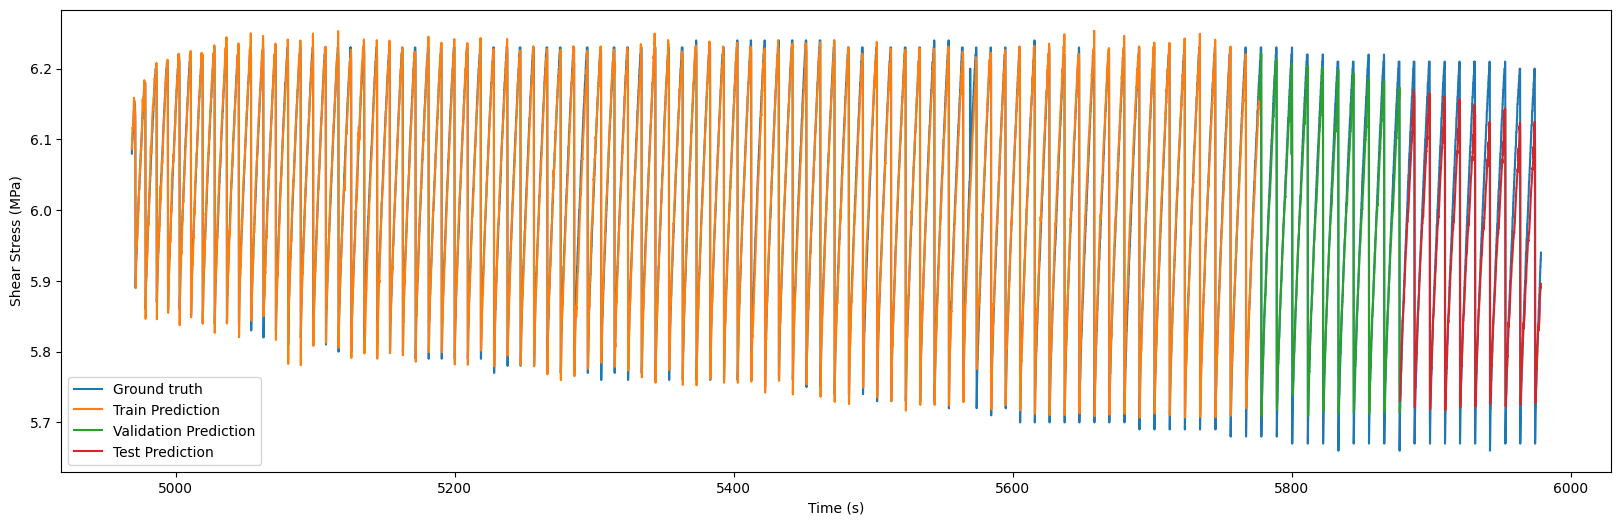

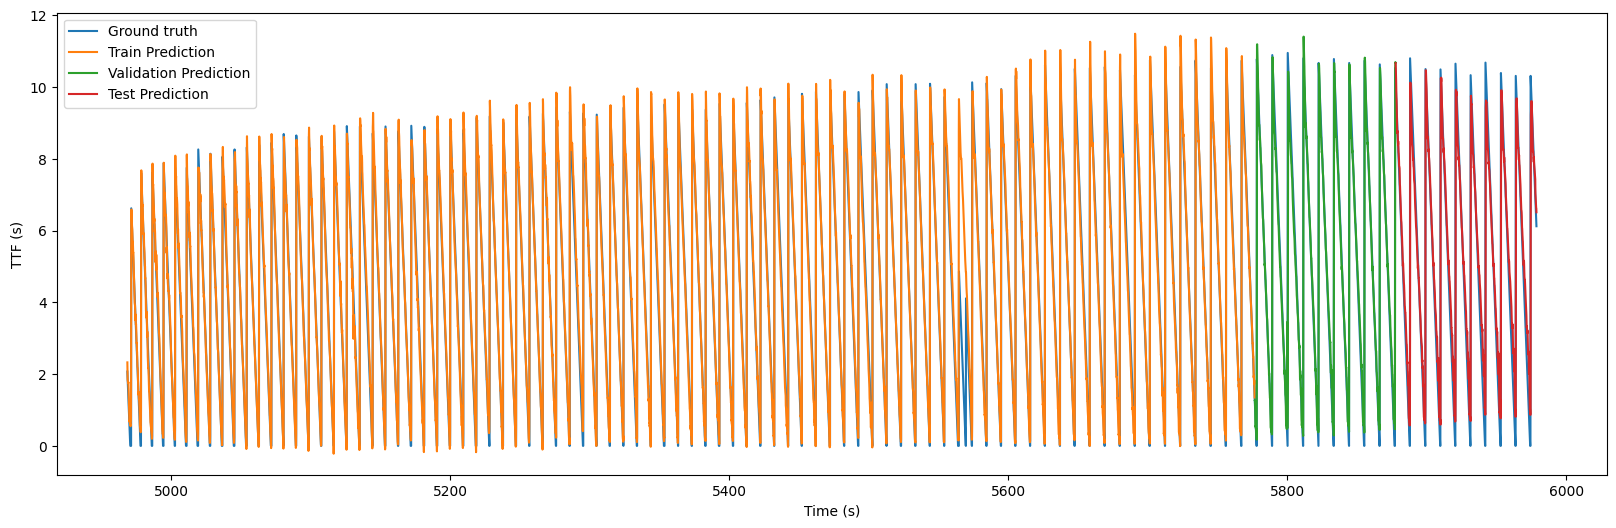

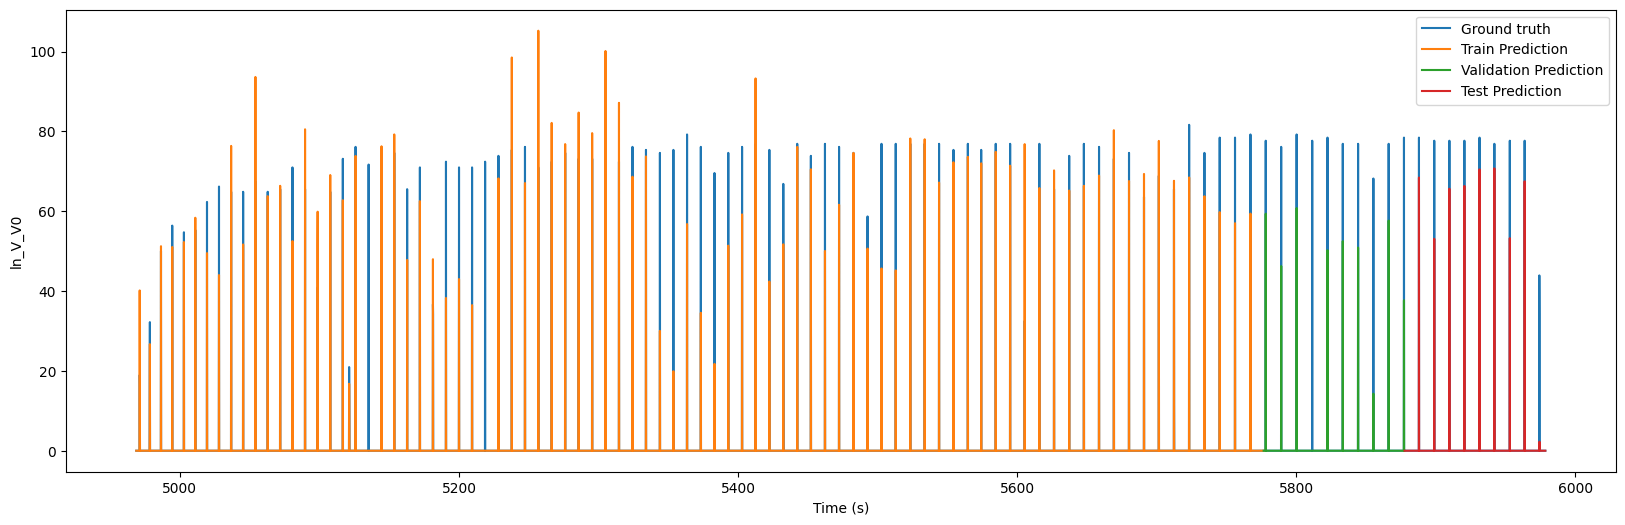

In [ ]:
# Overall plot:
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.1, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.111, shuffle=False)

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_TTF)
plt.plot(traintime, y_predtrain_TTF)
plt.plot(valtime,  y_predval_TTF)
plt.plot(testtime, y_predtest_TTF)
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

ydf_SR = np.exp(ydf_SR)*10;
y_predtrain_SR = np.exp(y_predtrain_SR)*10;
y_predval_SR = np.exp(y_predval_SR)*10;
y_predtest_SR = np.exp(y_predtest_SR)*10;

fig = plt.figure(3, figsize=(20,6))
plt.plot(ttime, ydf_SR)
plt.plot(traintime, y_predtrain_SR)
plt.plot(valtime,  y_predval_SR)
plt.plot(testtime, y_predtest_SR)
plt.xlabel('Time (s)')
plt.ylabel('ln_V_V0')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])


In [ ]:
# Extract Weights
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)

dense/kernel:0 (400, 128)
dense/bias:0 (128,)
dense_7/kernel:0 (100, 128)
dense_7/bias:0 (128,)
dense_1/kernel:0 (128, 64)
dense_1/bias:0 (64,)
dense_8/kernel:0 (128, 64)
dense_8/bias:0 (64,)
dense_2/kernel:0 (64, 32)
dense_2/bias:0 (32,)
dense_9/kernel:0 (64, 32)
dense_9/bias:0 (32,)
dense_3/kernel:0 (32, 16)
dense_3/bias:0 (16,)
dense_10/kernel:0 (32, 16)
dense_10/bias:0 (16,)
dense_4/kernel:0 (16, 8)
dense_4/bias:0 (8,)
dense_11/kernel:0 (16, 8)
dense_11/bias:0 (8,)
dense_5/kernel:0 (8, 1)
dense_5/bias:0 (1,)
dense_12/kernel:0 (8, 1)
dense_12/bias:0 (1,)
dense_6/kernel:0 (8, 1)
dense_6/bias:0 (1,)
c1:0 ()
c2:0 ()
c3:0 ()
c4:0 ()
gradient_1/dense_13/kernel:0 (1, 1)
gradient_1/dense_13/bias:0 (1,)
gradient_1/dense_14/kernel:0 (1, 1)
gradient_1/dense_14/bias:0 (1,)
gradient_1/dense_15/kernel:0 (1, 1)
gradient_1/dense_15/bias:0 (1,)
gradient_1/dense_16/kernel:0 (1, 1)
gradient_1/dense_16/bias:0 (1,)


In [ ]:
# Display Weights
model.get_weights()

[array([[ 0.03943938,  0.08199172,  0.07107114, ...,  0.04708095,
         -0.02004033, -0.24264184],
        [ 0.01088591,  0.00164849,  0.02529144, ...,  0.06524085,
          0.07006234, -0.30899972],
        [ 0.07024411,  0.36045417, -0.06221721, ...,  0.23702194,
          0.05557207, -0.08129351],
        ...,
        [ 0.01293047, -0.07641898, -0.00065955, ..., -0.00383149,
         -0.38398823,  0.2405349 ],
        [ 0.06049675, -0.36874953,  0.0177067 , ...,  0.15417439,
         -0.34828115,  0.25536382],
        [-0.01453077, -0.08678205,  0.06609059, ...,  0.10079889,
          0.1207535 , -0.0305286 ]], dtype=float32),
 array([-1.83525383e-02,  1.26462877e-01, -1.21523645e-02,  3.07629742e-02,
        -1.79500263e-02, -1.17099676e-02, -9.32120718e-03, -8.08957443e-02,
        -4.35114689e-02, -2.92814262e-02, -6.19658502e-03, -1.85796041e-02,
         4.43982854e-02,  1.19723052e-01,  1.32041387e-02, -7.18948897e-03,
        -8.40255022e-02, -7.99557269e-02,  3.99596877e

In [ ]:
# Get scale
r1 = scaler_ae.scale_.max()
r2 = scaler_A.scale_.max()
r3 = scaler_ss.scale_.max()
r4 = scaler_sr.scale_.max()
print(r1)
print(r2)
print(r3)
print(r4)

0.004132231404958678
1.0309278350515456
1.785714285714284
0.14695077149155034


In [ ]:
# # Rescale constant C1
cols = ['C1']
data = pd.DataFrame(np.array([[1.301509]]),columns=cols)
a = scaler_ss.inverse_transform(data)
Mu0 = a/9
print(Mu0)

[[0.71209389]]


In [ ]:
# # Rescale constant C2
cols = ['a']
data = pd.DataFrame(np.array([[1.4969751]]),columns=cols)
a = scaler_sr.inverse_transform(data)
a = (a*r1)/9
print(a)

[[0.00251695]]


In [ ]:
# # Rescale constant C3
cols = ['b']
data = pd.DataFrame(np.array([[1.3620516]]),columns=cols)
b = scaler_A.inverse_transform(data)
b = (b*r1)/9
print(b)

[[0.00492708]]


In [ ]:
# Rescale constant C4
Dc= math.exp(0.334937)
print(Dc)

1.3978523177523525
